# Adversarial Attack on Cyberharassment Detection Models

In this lab  (Adversarial attack on cyberharassment Detection models), you will add noise to the input of a cyberharassment model to make the model misclassify the input. This lab will walk you through this and will develop your intuition about adversarial attacks in AI models.

**You will learn:**
- How to deploy a pre-trained model
- How adversarial attack is generally structured
- How to attack an existing model
- Adversarial attack algorithms


## Required modules
First, run the cells below to import important packages needed for this lab. The second cell mounts Google drive which is where some files required for the lab will be stored. You will be prompted for authentication, please follow the instruction to authenticate.
- [numpy](https://www.numpy.org/) a Python package for scientific computing.
- [matplotlib](http://matplotlib.org) a Python library for visualization
- [PIL](http://www.pythonware.com/products/pil/) a Python package for image processing
- [torch](https://pytorch.org/) a Python open source source framework for deep learning


In [1]:
!pip install transformers

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

## Lab Overview

<img src="https://clemson.box.com/shared/static/lp073durs1970cvy9cboy5lwfytw6awh.png">

You are given a model that have been trained (pretrained) to detect not safe for work (NSFW) images. You are
also given a set pf NSFW test images. Of course building such models are important but as you will see in the
lab, such a model can be fooled to not detect such contents.

You will use adversarial algorithms to generate noise that will be added to the test images. When this modified
test image is passed through the model, the model will classify it as not NSFW even though it is.

## Data

We will use some NSFW images obtained by downloading images using the [ nsfw_data_scrapper](https://github.com/EBazarov/nsfw_data_source_urls). Each image belong to 1 of 5 categories (neutral, hentai, drawings, porn and sexy).
In our lab, we select hentai and drawings as NSFW and normal images. Each of the categories will be a folder containing images that belong to that category.

Let us explore the test dataset. Download the data by running the cell below.

In [3]:
# Download the dataset
if not Path('test').is_dir():
    !wget https://github.com/cuadvancelab/materials/raw/main/lab3/test.zip
    # Unzip it
    !unzip -q test.zip -d data/

--2023-11-21 17:00:19--  https://github.com/cuadvancelab/materials/raw/main/lab3/test.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cuadvancelab/materials/main/lab3/test.zip [following]
--2023-11-21 17:00:20--  https://raw.githubusercontent.com/cuadvancelab/materials/main/lab3/test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11096582 (11M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  10.58M  --.-KB/s    in 0.04s   

2023-11-21 17:00:21 (298 MB/s) - ‘test.zip’ saved [11096582/11096582]



Let us first use a custom dataset class to explore our dataset. After running the cell above, the category folders with the images were stored in a 'test' folder in your google drive. The code below retrieves an image from the category folders in 'test'.

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, image_directory, image_transform=None, label_transform=None):
        """
        Generate a single example and its label from image_directory
        Args:
            image_directory (String): The parent directory containing the directory that the images reside
            image_transform (NoneType): Transformation to apply to the image, defaults to None
            label_transform (NoneType): Transformation to apply to the image labels, defaults to None
        Retruns:
            example (Tuple): A tuple of tensors - image and label
        """

        if not os.path.exists(image_directory):
            raise ValueError(f"Input file {image_directory} does not exist")

        self.image_directory = image_directory
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.img_labels = []
        self.classes = ['normal', 'nsfw']

        for category in self.classes:
            files = os.listdir(self.image_directory + '/' + category)
            # Create a list of (image name, class folder) tuples
            self.img_labels.extend([(img_file, category) for img_file in files])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        # Read the image by getting its path: parent_directory/class/<name>.png
        image_path = self.img_labels[index][1] + "/" + self.img_labels[index][0]
        path = os.path.join(self.image_directory, image_path)
        image = Image.open(path).convert('RGB')
        label = self.classes.index(self.img_labels[index][1])

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        example = (image, label)

        return example

View the image at index 0 (the normal category)





class = 0, which is normal


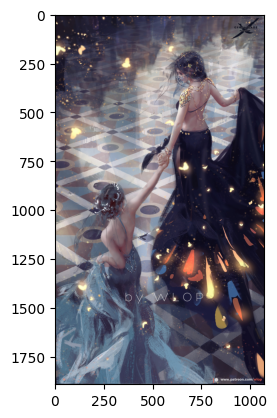

In [5]:
image_path = "data/test/"
test_data = CustomImageDataset(image_path,
                               image_transform=None,
                               label_transform=None)
index = 0
image, label = test_data[index]
plt.imshow(image)
print(f'class = {label}, which is {test_data.classes[label]}')


***
**<font color='red'>Task 1:</font>** Find the number of images there are in all category by replacing "None" with your code. <br> Don't access the attribute '\_\_len\_\_'. You can use the len function directly on the object of the CustomImageDataset class.
***


In [6]:
# Start code here #
total_number_of_images = len(test_data)
# End code here #

print(f"The number of images in the test dataset is: {total_number_of_images}")

The number of images in the test dataset is: 20


Now, use an built in PyTorch function to load the test dataset. We will use this built in function for the rest of this lab.

It is important to keep the dimension of all images the same, this allows to group a batch of images with the same shape into a single matrix/vector. We will perform some transformations on each image, for each image we make it a specific height and weight (224 x 224), center it, convert it to a tensor (converting the pixels into a vector) and normalize it. In this lab, we will batch our images into groups of 1 i.e each image is in its own batch.

In [7]:
# Transform the images to 224x224
image_transform = transforms.Compose(
    [transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])]
        )

# Create the dataset
test_dataset = datasets.ImageFolder(image_path, transform=image_transform)
class_dict = test_dataset.class_to_idx
# Set the batch size
batch_size = 1 # the batch size is 1 because we are going to generate adversarial examples for each image in the test dataset

# Batch dataset and create an iterator over the dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

***
**<font color='red'>Task 2:</font>** Questions:
- What is the size of an image and its label?
- What is the label index for different classes?

Each image should be of the shape (batch size, # channels, height, weight). Let's answer the questions with one sample in the dataset.

You can use the size() function to get the shape of a tensor and you can use the item() function to retrieve the element of a tensor.

Replace 'None' with the correct variable in the code below
***

In [8]:
classes =  list(class_dict.keys())
print(f"actual labels: {classes}")

# ===============================================
# View the shape and label with one example
# Start code here #
for image, label in test_dataloader:
    print(f"label index is: {label.item()}")
    image_size = image.size()
    label_size = label.size()
    label = classes[label.item()]
    break
# End code here #
# ===============================================

print(f"For the sample image, we have: \nImage size: {image_size}, label size: {label_size} and class: {label}")

actual labels: ['normal', 'nsfw']
label index is: 1
For the sample image, we have: 
Image size: torch.Size([1, 3, 224, 224]), label size: torch.Size([1]) and class: nsfw


---

## Evaluate the Pre-trianed Model

In this section, we will deploy a pre-trained NSFW detection model and evaluate the performance with the current test dataset.

In [9]:
# Use GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Let's use a pre-trained transformer model form Hugging face
from transformers import AutoModelForImageClassification, ViTImageProcessor

model = AutoModelForImageClassification.from_pretrained("Falconsai/nsfw_image_detection")
processor = ViTImageProcessor.from_pretrained('Falconsai/nsfw_image_detection')
model = model.to(device)

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Evaluate the model

In [11]:
# Evaluate the model on the test dataset
def evaluate(model, test_dataloader):
    """
    Evaluate the model on the test dataset
    Args:
        model (PyTorch model): The model to evaluate
        test_dataloader (PyTorch dataloader): The dataloader to use to generate predictions
    Returns:
        accuracy (float): The accuracy of the model on the test dataset
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for image, label in test_dataloader:
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            logits = outputs.logits
            predicted_label = logits.argmax(-1).item()
            if predicted_label == label.item():
                correct += 1
            total += 1
            # print(f"predicted label: {predicted_label}, actual label: {label.item()}")
    accuracy = correct / total
    return accuracy

***
**<font color='red'>Task 3:</font>** Now, please utilize the ```evaluate``` function and write your own code to print out the accuracy for the test dataset.
***

In [12]:
# ===============================================
# Start code here #
accuracy = evaluate(model, test_dataloader)
print(f"Accuracy of test data: {accuracy}")
# End code here #
# ===============================================

Accuracy of test data: 0.85


class = 0, which is normal
The predicted label is: normal with a score of: 0.9998693466186523


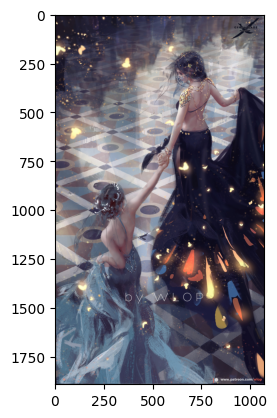

In [13]:
# A function for image input prediction
def model_predction(img):
    # use the model to predict the label
    with torch.no_grad():
        inputs = processor(images=img, return_tensors="pt").to(device)
        outputs = model(**inputs)
        logits = outputs.logits

        predicted_label = logits.argmax(-1).item()
        score = logits.softmax(-1)[0, predicted_label].item()
        return model.config.id2label[predicted_label], score

# Get one image to visualize and generate the prediction
image, label = test_data[index]
plt.imshow(image)
print(f'class = {label}, which is {test_data.classes[label]}')

# Generate the prediction
predicted_label, score = model_predction(image)
print(f"The predicted label is: {predicted_label} with a score of: {score}")

---

## White-box Attack

In a white-box attack, the adversary (the agent generating the adversarial examples) have knowledge about the target model architecture, its parameters and training data. We will be performing white-box attacks since we have a model that have been trained to detect NSFW, we have access to its parameters and we know the data it was trained on.

### FGSM Attacks
We will use fast gradient sign method (FGSM) to generate adversarial perturbations to fool the target model into predicting the wrong output.

Given an image $x$, FGSM generates an adversarial image $$x^{'} = x + ϵ * sign(∇_xJ(θ, x, l))$$

***
**<font color='red'>Task 4-1:</font>** Implement the FGSM formula in the code blow. Replace "None" with the formula.
***

Credit: The code in this section has been adapted from Nathan Inkawhich's work on adversarial example generation.

In [14]:
# implement FSGM attack fuction
def fgsm(image, epsilon, data_grad):
    """
    Perform the FGSM attack on a single image
    Args:
        image (torch.tensor): The image to be perturbed
        epsilon (float): Hyperparameter for controlling the scale of perturbation
        data_grad (): The gradient of the loss wrt to image
    Returns:
        perturbed_image (torch.tensor): a perturbed image
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()


    # ===============================================
    # Create the perturbed image by adjusting each pixel of the input image
    # Start code here ~ 1 line of code #
    perturbed_image = image + epsilon * sign_data_grad #𝒙′=𝒙 + 𝝐∗𝒔𝒊𝒈𝒏(𝛁𝒙 𝑱(𝜽,𝒙,𝒍))
    # End code here #
    # ===============================================

    # Adding clipping to maintain [0,1] range
    if epsilon != 0.0:
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

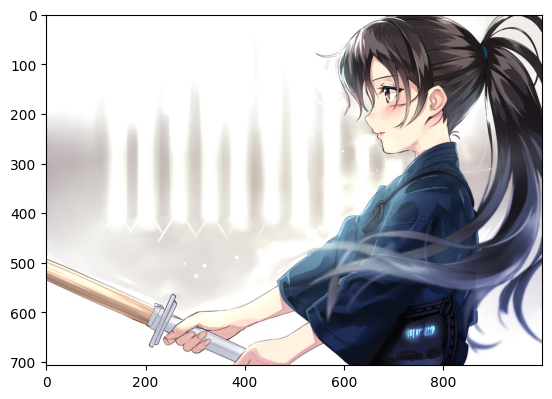

In [15]:
image, label = test_data[9]
plt.imshow(image)

***
**<font color='red'>Task 4-2:</font>** Complete the following code cell to:
- Perform a forward pass through the model using the original image
- Perform an FGSM attack by using ```fgsm``` function to generate an adversarial image
- Perform a forward pass through the model using the adversarial image
***

In [16]:
# get the prediction after FSGM attack
def fgsm_attack(model, test_dataloader, epsilon):
    """
    Perform the FGSM attack on a model by perturbing the test dataset
    Args:
        model (PyTorch model): The model to attack
        test_dataloader (PyTorch dataloader): The dataloader to use to generate predictions
        epsilon (float): Hyperparameter for controlling the scale of perturbation
    Returns:
        perturbed_images (torch.tensor): a tensor containing the perturbed images
        labels (torch.tensor): a tensor containing the labels of the perturbed images
        perturbed_labels (torch.tensor): a tensor containing the predicted labels of the perturbed images
    """
    # Create empty lists to store outputs
    perturbed_images = []
    labels = []
    perturbed_labels = []

    # Loop over the test dataset
    for image, label in test_dataloader:
        image = image.to(device)
        label = label.to(device)
        image.requires_grad = True

        # ===============================================
        # Start code here ~ 1 line of code #
        outputs = model(image)
        # End code here #
        # ===============================================

        logits = outputs.logits
        predicted_label = logits.argmax(-1).item()
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs.logits, label)
        model.zero_grad()
        loss.backward()

        data_grad = image.grad.data

        # ===============================================
        # Call FGSM to add perturbation to the data
        # Start code here ~ 1 line of code #
        perturbed_image = fgsm(image, epsilon, data_grad)
        # End code here #
        # ===============================================

        perturbed_images.append(perturbed_image)
        labels.append(label)

        # ===============================================
        # Re-classify the perturbed image
        # Start code here ~ 1 line of code #
        perturbed_label = model(perturbed_image)
        perturbed_label = perturbed_label.logits.argmax(-1).item() # you can also modify this line if you like
        # End code here #
        # ===============================================

        perturbed_labels.append(perturbed_label)

    # Return the perturbed images and labels
    return perturbed_images, labels, perturbed_labels


Execute FGSM attack

In [17]:
# Check the model performance after FGSM attack
fgsm_accuracies = []
fgsm_adversarial_examples = []
fgsm_original_labels = []
fgsm_predicion_labels = []

epsilons = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.14]

for eps in epsilons:
    correct = 0
    total = 0
    perturbed_images, labels, perturbed_labels = fgsm_attack(model, test_dataloader, eps)
    for i in range(len(perturbed_images)):
        if perturbed_labels[i] == labels[i]:
            correct += 1
        total += 1
    accuracy = correct / total
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_dataloader), accuracy))

    fgsm_accuracies.append(accuracy)
    fgsm_adversarial_examples.append(perturbed_images)
    fgsm_original_labels.append(labels)
    fgsm_predicion_labels.append(perturbed_labels)

Epsilon: 0.0	Test Accuracy = 17 / 20 = 0.85
Epsilon: 0.02	Test Accuracy = 11 / 20 = 0.55
Epsilon: 0.04	Test Accuracy = 11 / 20 = 0.55
Epsilon: 0.06	Test Accuracy = 9 / 20 = 0.45
Epsilon: 0.08	Test Accuracy = 9 / 20 = 0.45
Epsilon: 0.1	Test Accuracy = 9 / 20 = 0.45
Epsilon: 0.14	Test Accuracy = 9 / 20 = 0.45


Visualization

In [18]:
# Draw the accuracy vs epsilon figure
def plot_accuracy_vs_epsilon(epsilons, accuracies):
    plt.figure(figsize=(6,4))
    plt.plot(epsilons, accuracies, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .21, step=0.03))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

# Visualize 5 examples of the adversarial samples for each epsilon
def plot_adversarial_examples(adversarial_examples, epsilons, original_labels, predicion_labels):
    cnt = 0
    plt.figure(figsize=(10,10))
    for i in range(len(epsilons)):
        for j in range(5):
            cnt += 1
            plt.subplot(len(epsilons),5,cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=11)
                adv_image = adversarial_examples[i][j].reshape(3, 224, 224).squeeze().detach().cpu().numpy()
                adv_image = adv_image.transpose(1,2,0)

                plt.title("Label: {}".format(classes[original_labels[i][j]]) + "\n" + "Pred: {}".format(classes[predicion_labels[i][j]]))
            else:
                adv_image = adversarial_examples[i][j].reshape(3, 224, 224).squeeze().detach().cpu().numpy()
                adv_image = adv_image.transpose(1,2,0)

                plt.title("Label: {}".format(classes[original_labels[i][j]]) + "\n" + "Pred: {}".format(classes[predicion_labels[i][j]]))

            plt.imshow((adv_image))

    plt.tight_layout()
    plt.show()

***
**<font color='red'>Task 4-3:</font>** Run the following code cells to visualize the results from FGSM attack. Save the plots and attach them into your report.
***

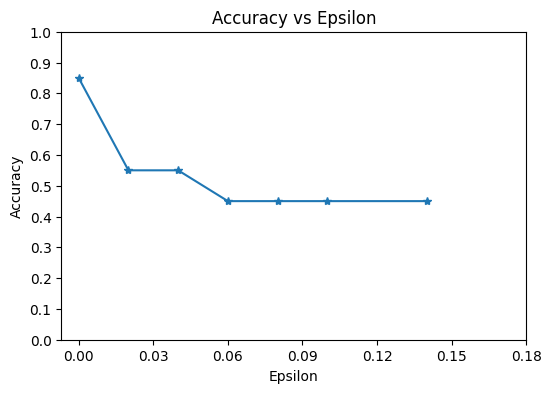

In [19]:
# Visualize accuracy vs epsilon
plot_accuracy_vs_epsilon(epsilons, fgsm_accuracies)

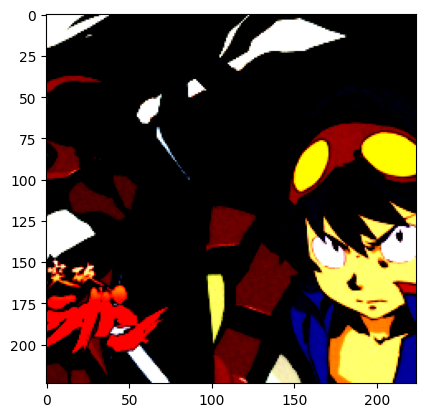

In [20]:
# Visualize the adversarial sample
image = fgsm_adversarial_examples[1][1]
image = image.reshape(3, 224, 224).squeeze().detach().cpu().numpy()
plt.imshow(image.transpose(1,2,0))

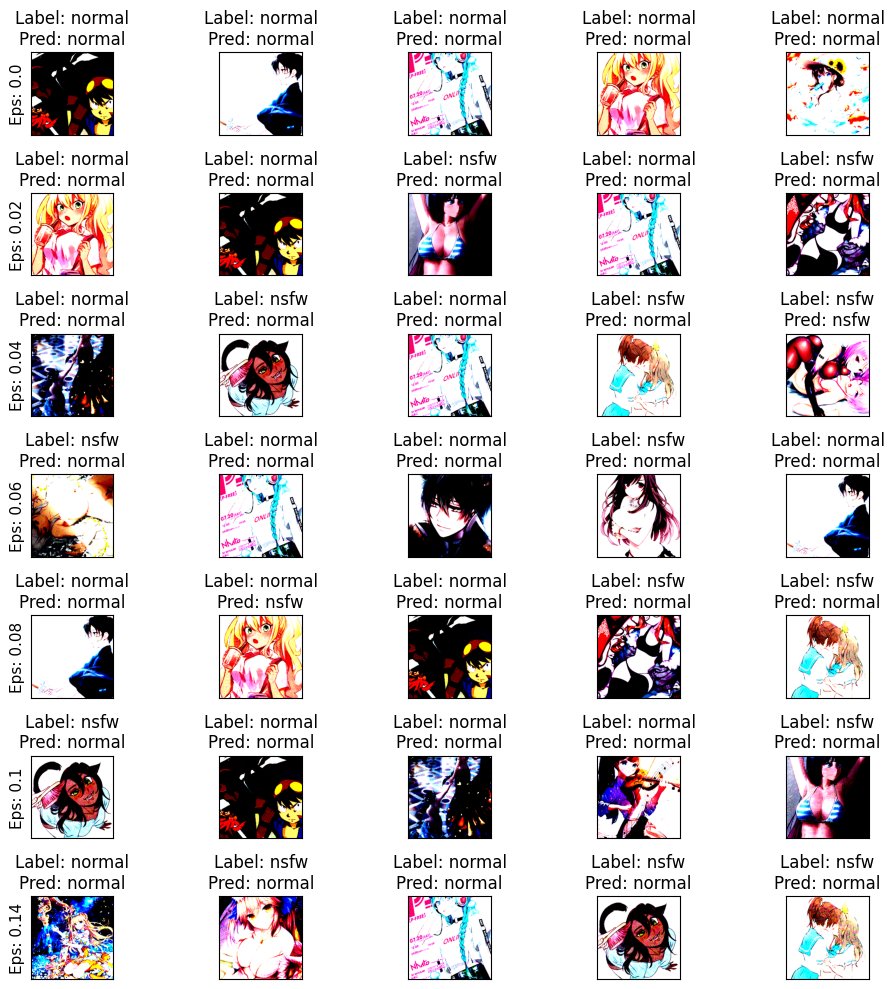

In [21]:
# Visualize the adversarial samples
plot_adversarial_examples(fgsm_adversarial_examples, epsilons, fgsm_original_labels, fgsm_predicion_labels)

---

### PGD Attacks

We will also use the projected gradient descent (PGD) method to generate adversarial examples.

Given a vectorized image $x$, PGD generates an adversarial image by
$$x^{'}_0 = x$$

> Repeat:
 $$x^{'}_{N+1} = Clip_x,_\epsilon \{x^{'}_N + \alpha * sign(∇_xJ(θ, x^{'}_N, l))\}$$

***
**<font color='red'>Task 5-1:</font>** Implement the PGD formula in the code blow. Replace "None" with the formula.
***

In [22]:
def pgd(model, image, label, epsilon, alpha, iterations):
    """
    Perform the PGD attack on an image
    Args:
        model (nn.Module): The NSFW model
        image (tensor): The images to be perturbed of shape [# channels, height, weight]
        label (tensor): The true labels of images of shape (1,)
        epsilon (float): Hyperparameter for controlling the scale of perturbation
        alpha (float): The step size i.e scale of the perturbation
        iterations (int): The number of iterations of images
    Returns:
        result (Tuple): A tuple of the perturbed image and the initial prediction for visualization purposes
    """

    image = image.to(device)
    label = label.to(device)
    original_image = image

    image.requires_grad = True
    output = model(image)
    init_pred = output.logits.argmax(-1)

    # If the initial prediction is wrong, dont bother attacking, just move on
    if init_pred.item() != label.item():
        return None, init_pred

    for i in range(iterations) :
        image.requires_grad = True
        output = model(image)
        logits = output.logits

        model.zero_grad()
        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, label)
        loss.backward()

        sign_data_grad = image.grad.sign()

        # ===============================================
        # Re-classify the perturbed image
        # Start code here ~ 1 line of code #
        perturbed_image = image + alpha * sign_data_grad #𝒙′𝑵+𝟏= 𝑪𝒍𝒊𝒑𝒙,𝝐 {𝒙′𝑵 + 𝜶∗𝒔𝒊𝒈𝒏(𝛁𝒙 𝑱(𝜽,𝒙′𝑵,𝒍))}
        # End code here #
        # ===============================================

        # Perform clipping
        eta = torch.clamp(perturbed_image - original_image, min = -epsilon, max = epsilon)
        image = torch.clamp(original_image + eta, min = 0, max = 1).detach_()

    return image, init_pred

***
**<font color='red'>Task 5-2:</font>** Complete the following code to:
- Perform an PGD attack by using the ```pgd``` function to generate an adversarial image
- Perform a forward pass through the model using the adversarial image
***

In [23]:
# get the prediction after PGD attack
def pgd_attack(model, test_dataloader, epsilon, alpha, iterations, mode):
    """
    Perform the PGD attack on a model by perturbing the test dataset
    Args:
        model (PyTorch model): The model to attack
        test_dataloader (PyTorch dataloader): The dataloader to use to generate predictions
        epsilon (float): Hyperparameter for controlling the scale of perturbation
        alpha (float): Hyperparameter for controlling the scale of perturbation
        iterations (int): The number of iterations to perform the attack
        mode (string): The mode of the attack, can be 'untargeted' or 'targeted'
    Returns:
        perturbed_images (torch.tensor): a tensor containing the perturbed images
        labels (torch.tensor): a tensor containing the labels of the original images
        perturbed_labels (torch.tensor): a tensor containing the predicted labels of the perturbed images
    """

    # We are not training, so set the model to evaluation mode
    model.eval()

    # Create empty lists to store outputs
    perturbed_images = []
    labels = []
    perturbed_labels = []

    # Loop over the test dataset

    for image, label in test_dataloader:
        image = image.to(device)
        label = label.to(device)

        # ===============================================
        # Start code here #
        perturbed_image, init_pred = pgd(model, image, label, epsilon, alpha, iterations)
        # End code here #
        # ===============================================

        if perturbed_image is not None:
            perturbed_images.append(perturbed_image)
            labels.append(label)

            # ===============================================
            # Start code here ~ 1-2 lines of code#
            perturbed_label = model(perturbed_image)
            perturbed_label = perturbed_label.logits.argmax(-1).item()

            # End code here #
            # ===============================================
            perturbed_labels.append(perturbed_label)

    # Return the perturbed images and labels
    return perturbed_images, labels, perturbed_labels

Execute PGD attack

In [24]:
# Run the PGD attack
pgd_accuracies = []
pgd_adversarial_examples = []
pgd_original_labels = []
pgd_predicion_labels = []

epsilons = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.14]
alpha = 0.01
iterations = 5

for eps in epsilons:
    correct = 0
    total = 0
    perturbed_images, labels, perturbed_labels = pgd_attack(model, test_dataloader, eps, alpha, iterations, 'untargeted')
    for i in range(len(perturbed_images)):
        if perturbed_labels[i] == labels[i]:
            correct += 1
        total += 1
    accuracy = correct / total
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, total, accuracy))

    pgd_accuracies.append(accuracy)
    pgd_adversarial_examples.append(perturbed_images)
    pgd_original_labels.append(labels)
    pgd_predicion_labels.append(perturbed_labels)


Epsilon: 0.0	Test Accuracy = 11 / 17 = 0.6470588235294118
Epsilon: 0.02	Test Accuracy = 9 / 17 = 0.5294117647058824
Epsilon: 0.04	Test Accuracy = 5 / 17 = 0.29411764705882354
Epsilon: 0.06	Test Accuracy = 5 / 17 = 0.29411764705882354
Epsilon: 0.08	Test Accuracy = 5 / 17 = 0.29411764705882354
Epsilon: 0.1	Test Accuracy = 5 / 17 = 0.29411764705882354
Epsilon: 0.14	Test Accuracy = 5 / 17 = 0.29411764705882354


***
**<font color='red'>Task 5-3:</font>** Complete and run the following code cells to visualize the results after PGD attack. Save the plots and attach them into your report.
***

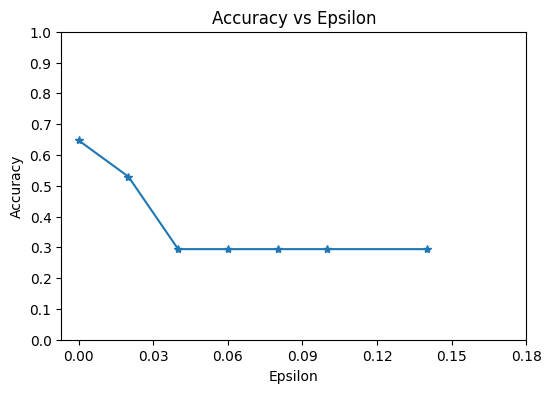

In [25]:
# Visualize accuracy vs epsilon
plot_accuracy_vs_epsilon(epsilons, pgd_accuracies)

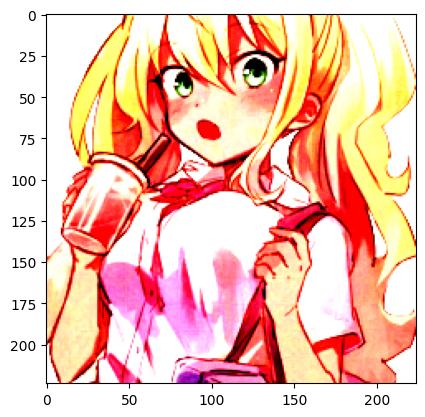

In [26]:
# Visualize an adversarial sample
image = pgd_adversarial_examples[3][1]
image = image.reshape(3, 224, 224).squeeze().detach().cpu().numpy()
plt.imshow(image.transpose(1,2,0))

In [ ]:
# Visualize 5 examples of the adversarial samples for each epsilon
plot_adversarial_examples(None, None, None, None)

***
**<font color='red'>Task 6:</font>** Compare the predictions of the original pre-trained model with the results after two attacks. Describe your observations and discuss the pros and cons of such white-box adversarial attacks.
***